# **Import Packages**

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Dataset**
The dataset was hosted in Kaggle, it contains over 8600 rows of data and each row has a person’s:
*   Type (This person’s 4 letter MBTI code/type)
*   A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))





In [5]:
text=pd.read_csv("drive/MyDrive/mbti_1.csv" ,index_col='type')
print(text.shape)
print(text[0:5])
#print(text.iloc[2])

(8675, 1)
                                                  posts
type                                                   
INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
ENTP  'I'm finding the lack of me in these posts ver...
INTP  'Good one  _____   https://www.youtube.com/wat...
INTJ  'Dear INTP,   I enjoyed our conversation the o...
ENTJ  'You're fired.|||That's another silly misconce...


# **Preprocessing**


The 16 labels are
transformed into one-hot encoding( categorical labels encoded into a binary representation where
one column denoting that label is with ’1’ with others as ’0’)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# One hot encode labels
labels=text.index.tolist()
encoder=LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
labels=encoder.fit_transform(labels)
labels=np.array(labels)
print(labels[50:55])

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


In [ ]:
mbti_dict={0:'ENFJ',1:'ENFP',2:'ENTJ',3:'ENTP',4:'ESFJ',5:'ESFP',6:'ESTJ',7:'ESTP',8:'INFJ',9:'INFP',10:'INTJ',11:'INTP',12:'ISFJ',13:'ISFP',14:'ISFP',15:'ISTP'}

 All the text data(posts) are converted
to lowercase. All the punctuations, URLs and links are removed using regular expressions. The
emojis/emoticons are left remained.

In [ ]:
import re

# Function to clean data..
def post_cleaner(post):
    """cleans individual posts`.
    Args:
        post-string
    Returns:
         cleaned up post`.
    """
    # Covert all uppercase characters to lower case
    post = post.lower() 
    
    # Remove |||
    post=post.replace('|||',"") 

    # Remove URLs, links etc
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 
    # This would have removed most of the links but probably not all 

    # Remove puntuations 
    puncs1=['@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']','|','\\','"',"'",';',':','<','>','/']
    for punc in puncs1:
        post=post.replace(punc,'') 

    puncs2=[',','.','?','!','\n']
    for punc in puncs2:
        post=post.replace(punc,' ') 
    # Remove extra white spaces
    post=re.sub( '\s+', ' ', post ).strip()
    return post

In [ ]:
posts=text.posts.tolist()
posts=[post_cleaner(post) for post in posts]

In [ ]:
from collections import Counter

word_count=Counter()
for post in posts:
    word_count.update(post.split(" "))
    
vocab_len=len(word_count)
print(vocab_len)

172984


 A look-up table was created (i.e., dictionary in Python) for
the vocabulary of the dataset, (which is already sorted decreasing based on the respective frequencies
of the words) which maps all the words to integers.All the words in the posts are then converted into
lists of integers according to the vocabulary

In [ ]:
vocab = sorted(word_count, key=word_count.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
posts_ints=[]

for post in posts:
    posts_ints.append([vocab_to_int[word] for word in post.split()])

Exception ignored in: <function BaseSession.__del__ at 0x7fdb812e30e0>
Traceback (most recent call last):
  File "/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py", line 761, in __del__
    if self._session is not None:
AttributeError: 'Session' object has no attribute '_session'


In [ ]:
print(posts_ints[0][:10])
print(len(posts_ints[0]))

[5, 141, 1287, 61293, 22, 703, 1850, 2069, 61294, 89]
566


In [ ]:
posts_lens = Counter([len(x) for x in posts])
#print(((np.mean(posts_lens.keys()))- (0.5*np.std(posts_lens.keys()))))

Since the lengths of the posts are varying, made all of them to a fixed size (say 1000 words) and
padded those posts with zeros if length of it is less than the size. This part is essential for neural
networks.

In [ ]:
seq_len = 1000                                                 #fixed post size=1000
features=np.zeros((len(posts_ints),seq_len),dtype=int)
for i, row in enumerate(posts_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]
#print(features[1555])

# **Splittig of training,validation and testing data**
The computed features split into sets for training, validation, testing in the ratio of
8:1:1

In [ ]:
split_frac = 0.8

num_ele=int(split_frac*len(features))
rem_ele=len(features)-num_ele
train_x, val_x = features[:num_ele],features[num_ele: num_ele + int(rem_ele/2)]
train_y, val_y = labels[:num_ele],labels[num_ele:num_ele + int(rem_ele/2)]

test_x =features[num_ele + int(rem_ele/2):]
test_y = labels[num_ele + int(rem_ele/2):]
print(test_x)
print(test_y)

[[   638      6     10 ...    385    566     41]
 [   118     55    178 ...     39    387   3038]
 [   166   1027    239 ...    106      4    169]
 ...
 [     0      0      0 ...      1      1    116]
 [     1     56     61 ...     54    177    564]
 [    10     89     72 ...  17928 172982     27]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
train_x.shape

(6940, 1000)

In [ ]:
lstm_size = 256
lstm_layers = 1
batch_size = 256
learning_rate = 0.01
embed_dim=250
n_words = len(vocab_to_int) + 1

In [ ]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)
int_to_vocab = {ii: word for word,ii in vocab_to_int.items()}

Exception ignored in: <function BaseSession.__del__ at 0x7fdb812e30e0>
Traceback (most recent call last):
  File "/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py", line 761, in __del__
    if self._session is not None:
AttributeError: 'Session' object has no attribute '_session'


In [ ]:
#model[int_to_vocab[2]]

In [ ]:
wv_emb = []
unk=[]
for k in range(1,len(int_to_vocab)):
    try:
        wv_emb.append(model[int_to_vocab[k]])
    except:
        unk.append(int_to_vocab[k])
len(unk)

116580

In [ ]:
unk[160:170]

['hisher',
 'winki',
 'thatd',
 'keirsey',
 'niti',
 'enxp',
 '36',
 '65',
 'favourites',
 'travelling']

# **Model Training**
The RNN implemented here consists of
an LSTM layer of 256 cells and then followed by two dense layers which finally gives away the
predicted class as the output. The first dense layer classifies the internal representation obtained from
the LSTM layer into a predicted class that is contained in 16 cells.The final Dense layer is meant to
be an output layer with softmax activation.

In [ ]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [ ]:
epochs = 1

with graph.as_default():
    saver = tf.train.Saver()


with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            
            feed = {input_data: x,
                    labels_: y,
                    keep_prob: 1.0,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {input_data: x,
                            labels_: y,
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/mbti.ckpt")


Epoch: 0/1 Iteration: 5 Train loss: 0.057
Epoch: 0/1 Iteration: 10 Train loss: 0.057
Epoch: 0/1 Iteration: 15 Train loss: 0.056
Epoch: 0/1 Iteration: 20 Train loss: 0.055
Epoch: 0/1 Iteration: 25 Train loss: 0.056
Val acc: 0.938


# **Accuracy Calculation**

In [ ]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {input_data: x,
                labels_: y,
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/mbti.ckpt
Test accuracy: 0.938


## **Twitter Data Extraction**

### Import Packages

In [ ]:
# Import os to work with the operating system
import os 

# Import tweepy to work with the twitter API
import tweepy as tw

# Import pandas to work with dataframes
import pandas as pd

**Twitter API**

In [ ]:
consumer_key = 'AmoloH4ZYyHU7SUKFiEivAOyZ'
consumer_secret = 'myNG6dCcgJOMqiDYbYU2KKrVaSU7kRtFSgJJJco5az86sTrOlu'
access_token = '4266273694-A5htSEDhcAKn5eBv4XyVAJgLNWIXJcDjOif9FKD'
access_token_secret = 'TFIbsA4BDmuBtVpVUdaTZc3Cll77pZRMilXaPitjk52wY'

In [ ]:
# Authenticate
auth = tw.OAuthHandler(consumer_key, consumer_secret)
# Set Tokens
auth.set_access_token(access_token, access_token_secret)
# Instantiate API
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
handle = 'muditasaboo'

In [ ]:
res = api.user_timeline(screen_name=handle, count=100, include_rts=True)

In [ ]:
tweets = [tweet.text for tweet in res]

In [ ]:
tweets

['@SmadhaviR Champion of last minute sangeets',
 '@UnnatiiiR @pYSLrada Please come. Please.',
 'friends we should not take ourselves so seriously, we are literally not even visible on the map. nothing matters guys just relax.',
 'what i miss the most is eating with others',
 '@UnnatiiiR Nice white roses',
 'RT @UnnatiiiR: "But if you knew, you might not be able to see it again tomorrow, everything would suddenly become special and precious, wou…',
 '@UnnatiiiR Ughhhhh I was already nostalgic max today :(',
 'RT @AnupamPKher: हाथ की लकीरें भी \nकितनी अजीब है, \nकम्बख़्त मुट्ठी में है \nलेकिन क़ाबू में नहीं… :)',
 '@kshismydada @UnnatiiiR ummm how will you stop now',
 '@andreagibson love this',
 '@SmadhaviR it is those in power who decide what is right, sad.',
 '@AllisonReichel @kaushalkarnani1 😂',
 '@Appyg99 @UnnatiiiR',
 '@kaysarahsera @MundadaNandini @SmadhaviR @UnnatiiiR',
 '@shakalse_single Bas tune bol diya yehi kaafi hain',
 '@fredtheredd17 https://t.co/hCOPQN0V60',
 'Toby is Seve

In [ ]:
text_live = ''.join(str(tweet) for tweet in tweets)

In [ ]:
text_live

'@SmadhaviR Champion of last minute sangeets@UnnatiiiR @pYSLrada Please come. Please.friends we should not take ourselves so seriously, we are literally not even visible on the map. nothing matters guys just relax.what i miss the most is eating with others@UnnatiiiR Nice white rosesRT @UnnatiiiR: "But if you knew, you might not be able to see it again tomorrow, everything would suddenly become special and precious, wou…@UnnatiiiR Ughhhhh I was already nostalgic max today :(RT @AnupamPKher: हाथ की लकीरें भी \nकितनी अजीब है, \nकम्बख़्त मुट्ठी में है \nलेकिन क़ाबू में नहीं… :)@kshismydada @UnnatiiiR ummm how will you stop now@andreagibson love this@SmadhaviR it is those in power who decide what is right, sad.@AllisonReichel @kaushalkarnani1 😂@Appyg99 @UnnatiiiR@kaysarahsera @MundadaNandini @SmadhaviR @UnnatiiiR@shakalse_single Bas tune bol diya yehi kaafi hain@fredtheredd17 https://t.co/hCOPQN0V60Toby is Severus, Pam is Lily, Jim is JamesMajor missing &lt;/3 https://t.co/0A1LGVhPB2@Krishn

In [ ]:
tweets[30:32]

['@siddharthmalu 💔💔💔💔💔💔',
 '“Sometimes, I think everything he did, feeding the poor on the streets, building the orphanage, giving money to fri… https://t.co/5VM0PeAb2b']

In [ ]:
len(tweets)

100

# **Preprocessing Tweets**

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# One hot encode labels
encoder=LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
labels=encoder.fit_transform(tweets)
labels=np.array(labels)
print(labels[50:55])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
posts=tweets
posts=[post_cleaner(post) for post in posts]

In [ ]:
from collections import Counter

word_count=Counter()
for post in posts:
    word_count.update(post.split(" "))
    
vocab_len=len(word_count)
print(vocab_len)

457


In [ ]:
vocab = sorted(word_count, key=word_count.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
posts_ints=[]

for post in posts:
    posts_ints.append([vocab_to_int[word] for word in post.split()])

In [ ]:
print(posts_ints[0][:10])
print(len(posts_ints[0]))

[4, 116, 39, 117, 118, 119]
6


In [ ]:
posts_ints[1]

[13, 120, 40, 59, 40]

### **Splitting Data**

In [ ]:
seq_len = 1000
features=np.zeros((len(posts_ints),seq_len),dtype=int)
for i, row in enumerate(posts_ints):
    if len(row)==0:
      row=[0]
    features[i, -len(row):] = np.array(row)[:seq_len]
#print(features[1555])


In [ ]:
features.shape

(100, 1000)

# **Predictions**

In [ ]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
   
    feed = {input_data: features,
            keep_prob: 1,
            initial_state: test_state}
    output = sess.run([predictions], feed_dict=feed)
    print(output)
    

INFO:tensorflow:Restoring parameters from checkpoints/mbti.ckpt
[array([[0.02486386, 0.08392687, 0.02495871, ..., 0.04153381, 0.04196287,
        0.05406826],
       [0.02438796, 0.07847609, 0.02602771, ..., 0.04462454, 0.04443046,
        0.04869099],
       [0.02228265, 0.08597611, 0.0218055 , ..., 0.03798951, 0.03857344,
        0.05386882],
       ...,
       [0.02331885, 0.08926487, 0.02201576, ..., 0.03700566, 0.03791092,
        0.05796258],
       [0.02634786, 0.09308912, 0.02385936, ..., 0.03709543, 0.03842542,
        0.06473851],
       [0.02473377, 0.08656339, 0.024103  , ..., 0.03979959, 0.04049136,
        0.05650879]], dtype=float32)]


In [ ]:
idx = np.argmax(output[0],axis=1)
    #idx=idx/100
    #idx=int(idx)
print(idx)
#print(mbti_dict[idx])

[9 8 9 9 9 9 9 9 9 9 9 9 9 9 8 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 8 9 8 9 8 9 9 8 9 9 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 9 9 9
 9 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9 8 9 9 9 9 9 9 9]


Prediction based on each tweet

In [ ]:
for i in idx:
  print(mbti_dict[i])

INFP
INFJ
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFJ
INFP
INFJ
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFJ
INFP
INFJ
INFP
INFJ
INFP
INFP
INFJ
INFP
INFP
INFP
INFP
INFJ
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFJ
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFJ
INFP
INFP
INFP
INFP
INFP
INFP
INFP
INFJ
INFP
INFP
INFP
INFP
INFP
INFP
INFP


### Overall Persoality Prediction

In [ ]:
p=int(np.mean(idx))

In [ ]:
q=np.mean(idx)
print(q)

8.89


In [ ]:
n=np.round(q)
print(n)

9.0


In [ ]:
print(mbti_dict[p])

INFJ


# **Visualisation**

In [ ]:
df=pd.read_csv("drive/MyDrive/mbti_1.csv")
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


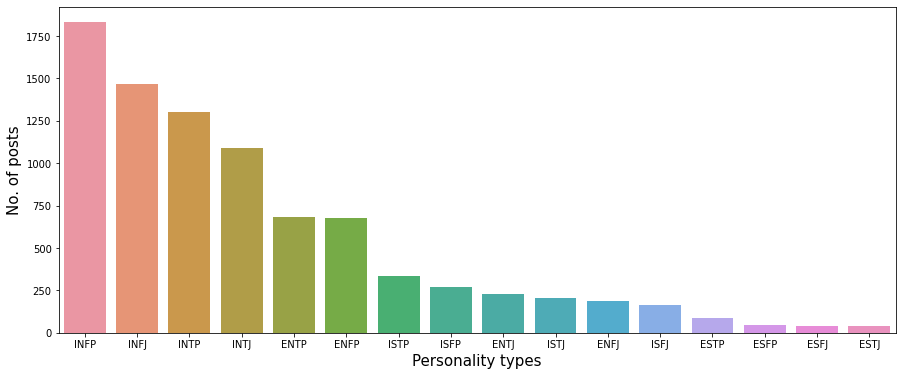

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
graph = df['type'].value_counts()
plt.figure(figsize=(15,6))
sb.barplot(graph.index, graph.values, alpha=1)
plt.xlabel('Personality types', fontsize=15)
plt.ylabel('No. of posts', fontsize=15)
plt.show()